In [1]:
import gymnasium as gym
import numpy as np
from IPython.display import clear_output, display

import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib qt 
plt.ion()

import torch
import torch.nn as nn
import torch.nn.functional as F
import time

RENDER_HUMAN = True
if RENDER_HUMAN:
    env = gym.make('Pendulum-v1', render_mode="human")
else:
    env = gym.make('Pendulum-v1')

print("Action Space: ", env.action_space)
print("Obs Space: ", env.observation_space)


SEED = 2147483647
# SEED = 0

# torch.manual_seed(SEED)

Action Space:  Box(-2.0, 2.0, (1,), float32)
Obs Space:  Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


So in v2, I got prediction on 4 state (x,y,velocity,reward)

Can I instead now due the learning purely via PID?

In [2]:
g = torch.Generator().manual_seed(SEED)

# Create NN Parameters
W1 = torch.randn((3,4), generator=g)  * 0.1
b1 = torch.randn((4), generator=g) *  0.01
p1 = torch.randn((4), generator=g) *  0.01 
# p1 = torch.randn((4), generator=g, requires_grad=True) *  0.01  #This causes a bug in the backward pass!!!

params = [W1, b1]

for p in params:
    p.requires_grad = True
p1.requires_grad = True
n_params = sum(p.numel() for p in params)

print("Network Params: ", n_params)

Network Params:  16


In [3]:
#reward is usally between 0 and -16.2736044

max_reward = 0
min_reward = -16.2736044
avg_reward = (max_reward+min_reward)/2
spread = abs(max_reward - min_reward)

In [4]:
action = env.action_space.sample()  #first action is random

In [5]:
curr_obs_raw, info = env.reset(seed=SEED)
curr_obs = torch.tensor(curr_obs_raw) / torch.tensor([1, 1, 8])

In [75]:

last_loss = 0 #always <= 0
last_grad = torch.zeros((4)) 
kp = 0.1 #positive so you step in the right direction

losses = []
time_steps = []  

for _ in range(10):
    # Forward Pass, make prediction based on current state
    output = curr_obs @ W1 + b1 + p1
    next_obs_pred = torch.tanh(output)

    # time step forward
    next_obs_raw, reward_raw, terminated, truncated, info = env.step(np.array([0]))
    reward = (reward_raw - avg_reward) / (spread * 0.5)

    next_obs = torch.tensor(next_obs_raw) / torch.tensor([1, 1, 8])
    curr_obs = next_obs # reassign for next loop

    next_obs_with_reward = torch.cat((next_obs, torch.tensor([reward])), dim=0).float()

    # Backward pass - calculate prediction error + backprop
    # print(f"pred: {next_obs_pred[3]} actual: {next_obs_with_reward[3]}")

    # loss = F.mse_loss(next_obs_pred[3], next_obs_with_reward[3])
    print("pred: ", next_obs_pred)
    print("actual: ", next_obs_with_reward)
    print("diff: ", next_obs_with_reward-next_obs_pred)
    
    loss = F.mse_loss(next_obs_pred, next_obs_with_reward)
    loss_val = loss.item()
    print("loss: ", loss_val)
    losses.append(loss_val)
    time_steps.append(_)


    for p in params:
        p.grad = None

    p1.grad = None

    loss.backward()

    # for p in params:
    #     p.data += -0.05 * p.grad

    print("grad: ", p1.grad)
    print("data before: ", p1.data)
    p1.data = -0.01 * loss_val * p1.grad 
    print("data after: ", p1.data)

    if terminated or truncated:
        curr_obs_raw, info = env.reset(seed=SEED)
        curr_obs = torch.tensor(curr_obs_raw) / torch.tensor([1, 1, 8])
    clear_output(wait=True)



pred:  tensor([-0.2252, -0.1323, -0.0539, -0.0405], grad_fn=<TanhBackward0>)
actual:  tensor([ 0.0219, -0.9998,  0.4518,  0.3993])
diff:  tensor([ 0.2471, -0.8675,  0.5056,  0.4398], grad_fn=<SubBackward0>)
loss:  0.31566476821899414
grad:  tensor([-0.1173,  0.4261, -0.2521, -0.2195])
data before:  tensor([ 6.4252e-05, -1.3275e-03,  9.0809e-04,  3.9939e-04])
data after:  tensor([ 0.0004, -0.0013,  0.0008,  0.0007])


In [16]:
# env.close()

In [14]:

class DynamicPlot():
    #Suppose we know the x range
    def __init__(self, window=10):
        #Set up plot
        self.figure, self.ax = plt.subplots()
        self.lines, = self.ax.plot([],[], 'o')
        self.window = window
        #Autoscale on unknown axis and known lims on the other
        self.ax.set_autoscaley_on(True)
        self.ax.set_xlim(0, self.window)
        #Other stuff
        self.ax.grid()
        
    def update(self, xdata, ydata):
        #Update data (with the new _and_ the old points)
        self.lines.set_xdata(xdata)
        self.lines.set_ydata(ydata)
        #Need both of these in order to rescale
        self.ax.set_xlim(xdata[-1]-self.window, xdata[-1])
        self.ax.relim()
        self.ax.autoscale_view()
        #We need to draw *and* flush
        self.figure.canvas.draw()
        self.figure.canvas.flush_events()

plot = DynamicPlot()

In [7]:
t = 0

In [18]:

last_loss = 0 #always <= 0
last_grad = torch.zeros((4)) 
kp = 0.1 #positive so you step in the right direction

losses = []
time_steps = []  
preds = []
reality = []

for _ in range(10):
    t += 1
    # Forward Pass, make prediction based on current state
    output = curr_obs @ W1 + b1 + p1
    next_obs_pred = torch.tanh(output)

    # time step forward
    next_obs_raw, reward_raw, terminated, truncated, info = env.step(np.array([0]))
    reward = (reward_raw - avg_reward) / (spread * 0.5)

    next_obs = torch.tensor(next_obs_raw) / torch.tensor([1, 1, 8])
    curr_obs = next_obs # reassign for next loop

    next_obs_with_reward = torch.cat((next_obs, torch.tensor([reward])), dim=0).float()

    loss = F.mse_loss(next_obs_pred, next_obs_with_reward)
    loss_val = loss.item()
    print("loss: ", loss_val)
    losses.append(loss_val)
    time_steps.append(t)

    preds.append(next_obs_pred.detach().numpy()[0])
    # reality.append(next_obs_with_reward[0])
    
    for p in params:
        p.grad = None

    p1.grad = None

    loss.backward()

    # for p in params:
    #     p.data += -0.05 * p.grad

    p1.data = -0.01 * loss_val * p1.grad 

    if terminated or truncated:
        curr_obs_raw, info = env.reset(seed=SEED)
        curr_obs = torch.tensor(curr_obs_raw) / torch.tensor([1, 1, 8])
    clear_output(wait=True)
    plot.update(time_steps,preds)



loss:  0.41533705592155457


0.3629282366040718


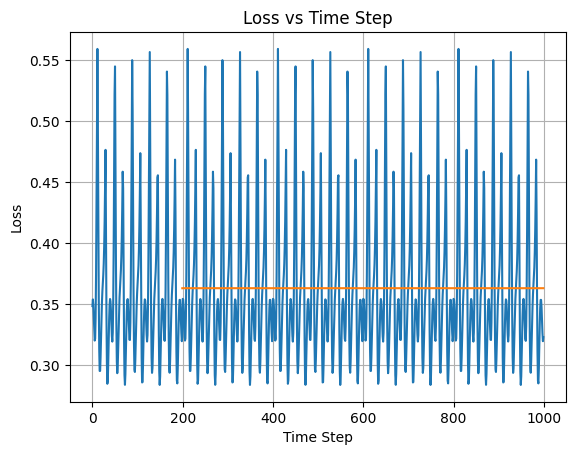

In [92]:

plt.plot(time_steps, losses, label='Raw Loss')

smooth_loss = np.convolve(losses, np.ones(200) / 200, mode='valid')
print(np.mean(smooth_loss))
plt.plot(time_steps[len(time_steps) - len(smooth_loss):], smooth_loss, label='Smoothed Loss')

plt.xlabel('Time Step')
plt.ylabel('Loss')
plt.title('Loss vs Time Step')
plt.grid(True)
plt.show()

step at 1

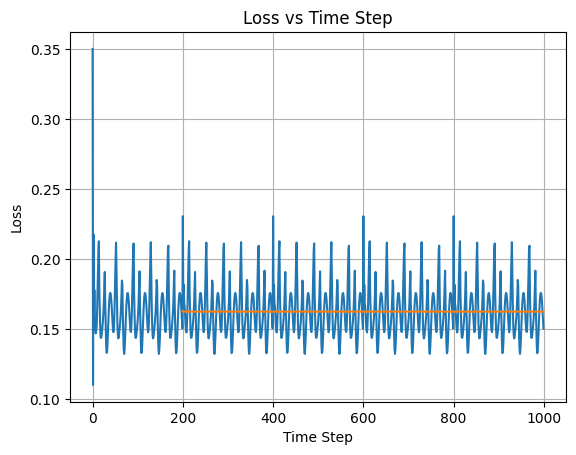


step 0.01

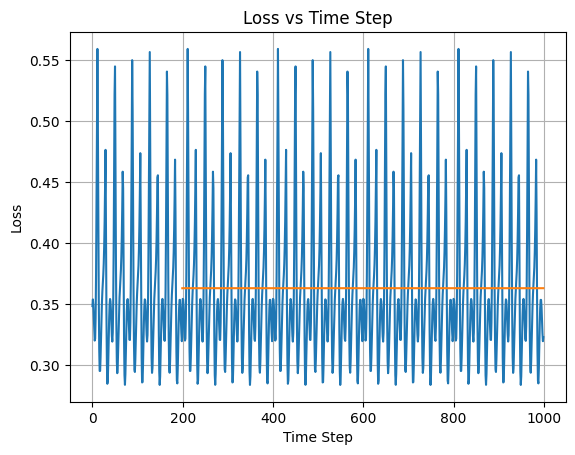